In [2]:
# conda install -c conda-forge shap
# pip install xgboost
# pip install lightgbm

## Model
1. xgboost
1. lightgbm 
1. RandomForest

-> Ensemble

In [70]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import shap
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#Reading the train and test files
os.chdir('C:\\Users\\zerod\\data02')
train_prod_df = pd.read_csv('train.csv')
test_prod_df = pd.read_csv('test.csv')

In [7]:
train_prod_df.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


In [8]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [9]:
#Converting the employee1 and 2 column as float in the train set as done for the test dataset
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

In [10]:
#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [11]:
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])


train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
np.random.seed(100)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

In [13]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [14]:
rf = RandomForestClassifier()
rf_tmp = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [15]:
rf_tmp.fit(train_prod_X, train_prod_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [16]:
rf_tmp.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 106}

In [1]:
############################################################################
############ Random Forest with hyper-parameter tuning
############################################################################
estimators = 106
max_depth_tune = None
max_features_tune = 'sqrt'

np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators,
                                max_depth = max_depth_tune,
                                max_features = max_features_tune)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF_tune = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF_tune = sub_RF_tune[['inst_id', 'OC']]

NameError: name 'np' is not defined

In [93]:
sub_RF_tune

,inst_id,OC
0,2,0.962264
1,5,0.811321
2,6,0.584906
3,8,0.801887
4,10,0.933962
5,12,0.962264
6,13,1.000000
7,20,0.981132
8,21,0.754717
9,23,0.990566


In [94]:
sub_RF_tune['OC'] = [1 if oc>=0.7 else 0 for oc in sub_RF_tune['OC']]

In [95]:
sub_RF_tune

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
5,12,1
6,13,1
7,20,1
8,21,1
9,23,1


In [32]:
############################################################################
############ Random Forest
############################################################################
estimators = 10
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]

In [33]:
sub_RF

,inst_id,OC
0,2,0.8
1,5,0.8
2,6,0.6
3,8,0.8
4,10,0.9
5,12,1.0
6,13,1.0
7,20,1.0
8,21,0.7
9,23,1.0


In [34]:
sub_RF['OC'] = [1 if oc>=0.7 else 0 for oc in sub_RF['OC']]

In [35]:
sub_RF

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
5,12,1
6,13,1
7,20,1
8,21,1
9,23,1


In [37]:
test_prod_tmp = test_prod[['inst_id', 'OC']]
test_prod_tmp

,inst_id,OC
0,2,1
1,5,0
2,6,0
3,8,1
4,10,1
5,12,1
6,13,1
7,20,1
8,21,1
9,23,1


In [97]:
y_prod_tune = list(sub_RF_tune['OC'])
y_prod = list(sub_RF['OC'])
y_true = list(test_prod_tmp['OC'])

In [98]:
# original
print(classification_report(y_true, y_prod, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod)

             precision    recall  f1-score   support

    class 0       0.67      0.46      0.55        13
    class 1       0.94      0.97      0.96       114

avg / total       0.91      0.92      0.91       127



0.9212598425196851

In [99]:
#tuning
print(classification_report(y_true, y_prod_tune, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod_tune)

             precision    recall  f1-score   support

    class 0       0.75      0.69      0.72        13
    class 1       0.97      0.97      0.97       114

avg / total       0.94      0.94      0.94       127



0.9448818897637795

In [16]:
############################################################################
############ GBM
############################################################################
estimators = 10
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]

In [80]:
############################################################################
############ XGBOOST - tuning
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param_tmp = {'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
         'eta': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
         }

nrounds = 2

In [83]:
xgb_classifier = XGBClassifier(n_estimators=600, objective='binary:logistic',nthread=1)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

random_xgb_tmp = RandomizedSearchCV(xgb_classifier, param_distributions=param_tmp, n_iter=5, scoring='roc_auc', n_jobs=4, cv=skf.split(train_prod_X, train_prod_Y), verbose=3, random_state=42)

In [84]:
random_xgb_tmp.fit(train_prod_X, train_prod_Y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   44.1s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000266CA50EBF8>,
          error_score='raise',
          estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
          fit_params=None, iid=True, n_iter=5, n_jobs=4,
          param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'eta': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [85]:
print('\n All results:')
print(random_xgb_tmp.cv_results_)
print('\n Best estimator:')
print(random_xgb_tmp.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (3, 5))
print(random_xgb_tmp.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_xgb_tmp.best_params_)
results = pd.DataFrame(random_xgb_tmp.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([0.66987499, 1.0465343 , 0.98469861, 0.83393908, 0.90010389]), 'std_fit_time': array([0.06525237, 0.04834936, 0.15362259, 0.0271486 , 0.0212973 ]), 'mean_score_time': array([0.0069809 , 0.01196766, 0.00764696, 0.00831175, 0.00731373]), 'std_score_time': array([0.00081439, 0.00430936, 0.0004698 , 0.00124369, 0.00094122]), 'param_max_depth': masked_array(data=[6, 3, 5, 6, 3],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_eta': masked_array(data=[0.08, 0.1, 0.08, 0.1, 0.08],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 6, 'eta': 0.08}, {'max_depth': 3, 'eta': 0.1}, {'max_depth': 5, 'eta': 0.08}, {'max_depth': 6, 'eta': 0.1}, {'max_depth': 3, 'eta': 0.08}], 'split0_test_score': array([0.71979167, 0.75208333, 0.703125  , 0.73229167, 0.7625    ]), 'split1_test_score': array([0.64842105, 0.62      , 0.6484

You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True


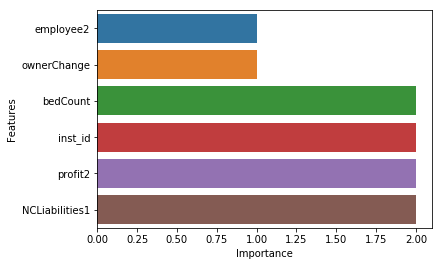

In [103]:
np.random.seed(100)
best_param = {'max_depth' : 3,
         'eta': 0.08
         }

xgb_model_tune = xgb.train(best_param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model_tune.predict(dtest_prod)

sub_XGB_tune= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB_tune= sub_XGB_tune[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model_tune.get_score().keys()), 
                        'Importance' : list(xgb_model_tune.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
plt.show()

In [104]:
sub_XGB_tune

,inst_id,OC
0,2,0.574306
1,5,0.539200
2,6,0.542465
3,8,0.574306
4,10,0.574306
5,12,0.574306
6,13,0.574306
7,20,0.574306
8,21,0.574306
9,23,0.574306


In [105]:
sub_XGB_tune['OC'] = [1 if oc>=0.5 else 0 for oc in sub_XGB_tune['OC']]
sub_XGB_tune

,inst_id,OC
0,2,1
1,5,1
2,6,1
3,8,1
4,10,1
5,12,1
6,13,1
7,20,1
8,21,1
9,23,1


In [106]:
############################################################################
############ XGBOOST
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0
         }

nrounds = 2

[17:10:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




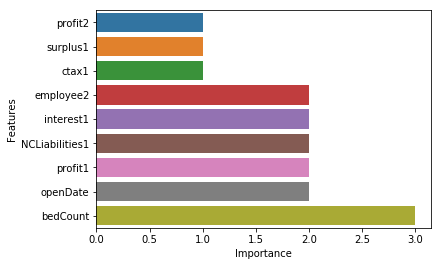

In [107]:
np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
plt.show()

In [108]:
sub_XGB

,inst_id,OC
0,2,0.705177
1,5,0.655411
2,6,0.409096
3,8,0.645067
4,10,0.705177
5,12,0.709663
6,13,0.739121
7,20,0.739121
8,21,0.708361
9,23,0.705177


In [110]:
sub_XGB['OC'] = [1 if oc>=0.5 else 0 for oc in sub_XGB['OC']]
sub_XGB

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
5,12,1
6,13,1
7,20,1
8,21,1
9,23,1


In [111]:
y_prod_tune_xgb = list(sub_XGB_tune['OC'])
y_prod_xgb = list(sub_XGB['OC'])
y_true = list(test_prod_tmp['OC'])

In [112]:
# original
print(classification_report(y_true, y_prod_xgb, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod_xgb)

             precision    recall  f1-score   support

    class 0       0.75      0.92      0.83        13
    class 1       0.99      0.96      0.98       114

avg / total       0.97      0.96      0.96       127



0.9606299212598425

In [113]:
# tuning
print(classification_report(y_true, y_prod_tune_xgb, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod_tune_xgb)

             precision    recall  f1-score   support

    class 0       0.89      0.62      0.73        13
    class 1       0.96      0.99      0.97       114

avg / total       0.95      0.95      0.95       127



0.952755905511811

In [33]:
ensemble

,inst_id,OC
0,2,1
1,5,0
2,6,0
3,8,1
4,10,1
...,...,...
122,424,0
123,425,0
124,429,0
125,430,1


In [34]:
# accuracy 96.063

In [28]:
test_prod

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,0,10,139,19981125.0,300.0,3,6.682486e+10,0.000000e+00,6.565709e+10,...,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693.0,693.0,2
1,5,0,11,149,20160309.0,44.0,4,3.495758e+10,0.000000e+00,3.259270e+10,...,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379.0,371.0,2
2,6,0,13,103,19890427.0,276.0,3,2.326031e+10,2.542571e+09,2.308749e+10,...,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,-999.0,-999.0,0
3,8,0,0,71,20100226.0,363.0,3,0.000000e+00,0.000000e+00,0.000000e+00,...,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760.0,760.0,2
4,10,0,12,26,20040604.0,213.0,3,5.037025e+10,0.000000e+00,4.855803e+10,...,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437.0,385.0,2
5,12,0,8,122,20081224.0,220.0,3,4.381654e+10,1.005131e+10,2.926493e+10,...,4.545911e+10,2.475716e+10,1.755790e+10,2.070195e+10,1.716934e+10,2.480949e+10,0.000000e+00,386.0,397.0,2
6,13,0,8,31,20020513.0,370.0,3,8.622773e+10,2.196138e+10,6.151972e+10,...,4.236725e+10,2.587879e+10,1.197931e+10,1.648845e+10,1.381123e+10,3.447421e+10,0.000000e+00,727.0,580.0,2
7,20,0,12,147,20070110.0,246.0,3,3.570973e+10,4.188687e+09,3.000179e+10,...,2.275405e+10,8.100283e+09,3.139853e+09,1.465377e+10,1.226653e+10,6.194693e+09,1.577122e+09,377.0,346.0,2
8,21,0,7,95,20151209.0,148.0,5,2.719142e+09,0.000000e+00,2.067186e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,17.0,17.0,2
9,23,0,8,169,19851223.0,27.0,4,7.034041e+10,1.570361e+10,5.177418e+10,...,6.241929e+10,1.514333e+10,7.749623e+09,4.727596e+10,3.331840e+10,9.818765e+09,8.483183e+09,532.0,409.0,2


In [20]:
close_idx = [5, 6, 24, 30 ,64, 123, 229, 258, 293, 341, 425, 429, 431]
test_prod['OC'] = [0 if id in close_idx else 1 for id in test_prod['inst_id']]

test_prod    


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,1,10,139,19981125.0,300.0,3,6.682486e+10,0.000000e+00,6.565709e+10,...,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693.0,693.0,2
1,5,0,11,149,20160309.0,44.0,4,3.495758e+10,0.000000e+00,3.259270e+10,...,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379.0,371.0,2
2,6,0,13,103,19890427.0,276.0,3,2.326031e+10,2.542571e+09,2.308749e+10,...,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,-999.0,-999.0,0
3,8,1,0,71,20100226.0,363.0,3,0.000000e+00,0.000000e+00,0.000000e+00,...,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760.0,760.0,2
4,10,1,12,26,20040604.0,213.0,3,5.037025e+10,0.000000e+00,4.855803e+10,...,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437.0,385.0,2
5,12,1,8,122,20081224.0,220.0,3,4.381654e+10,1.005131e+10,2.926493e+10,...,4.545911e+10,2.475716e+10,1.755790e+10,2.070195e+10,1.716934e+10,2.480949e+10,0.000000e+00,386.0,397.0,2
6,13,1,8,31,20020513.0,370.0,3,8.622773e+10,2.196138e+10,6.151972e+10,...,4.236725e+10,2.587879e+10,1.197931e+10,1.648845e+10,1.381123e+10,3.447421e+10,0.000000e+00,727.0,580.0,2
7,20,1,12,147,20070110.0,246.0,3,3.570973e+10,4.188687e+09,3.000179e+10,...,2.275405e+10,8.100283e+09,3.139853e+09,1.465377e+10,1.226653e+10,6.194693e+09,1.577122e+09,377.0,346.0,2
8,21,1,7,95,20151209.0,148.0,5,2.719142e+09,0.000000e+00,2.067186e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,17.0,17.0,2
9,23,1,8,169,19851223.0,27.0,4,7.034041e+10,1.570361e+10,5.177418e+10,...,6.241929e+10,1.514333e+10,7.749623e+09,4.727596e+10,3.331840e+10,9.818765e+09,8.483183e+09,532.0,409.0,2
